
Training Genetic Algorithm...
Gen 1/500 - Best Fitness: 9.63909
Gen 2/500 - Best Fitness: 9.63909
Gen 3/500 - Best Fitness: 10.58863
Gen 4/500 - Best Fitness: 13.07424
Gen 5/500 - Best Fitness: 13.07424
Gen 6/500 - Best Fitness: 13.48840
Gen 7/500 - Best Fitness: 23.03041
Gen 8/500 - Best Fitness: 23.03041
Gen 9/500 - Best Fitness: 23.03041
Gen 10/500 - Best Fitness: 23.03041
Gen 11/500 - Best Fitness: 23.08273
Gen 12/500 - Best Fitness: 23.65813
Gen 13/500 - Best Fitness: 24.02008
Gen 14/500 - Best Fitness: 24.02008
Gen 15/500 - Best Fitness: 24.02008
Gen 16/500 - Best Fitness: 24.02008
Gen 17/500 - Best Fitness: 25.86902
Gen 18/500 - Best Fitness: 25.86902
Gen 19/500 - Best Fitness: 26.30844
Gen 20/500 - Best Fitness: 26.30844
Gen 21/500 - Best Fitness: 27.10823
Gen 22/500 - Best Fitness: 27.10823
Gen 23/500 - Best Fitness: 27.20350
Gen 24/500 - Best Fitness: 27.20350
Gen 25/500 - Best Fitness: 27.79155
Gen 26/500 - Best Fitness: 28.24947
Gen 27/500 - Best Fitness: 28.24947
Gen 28/5

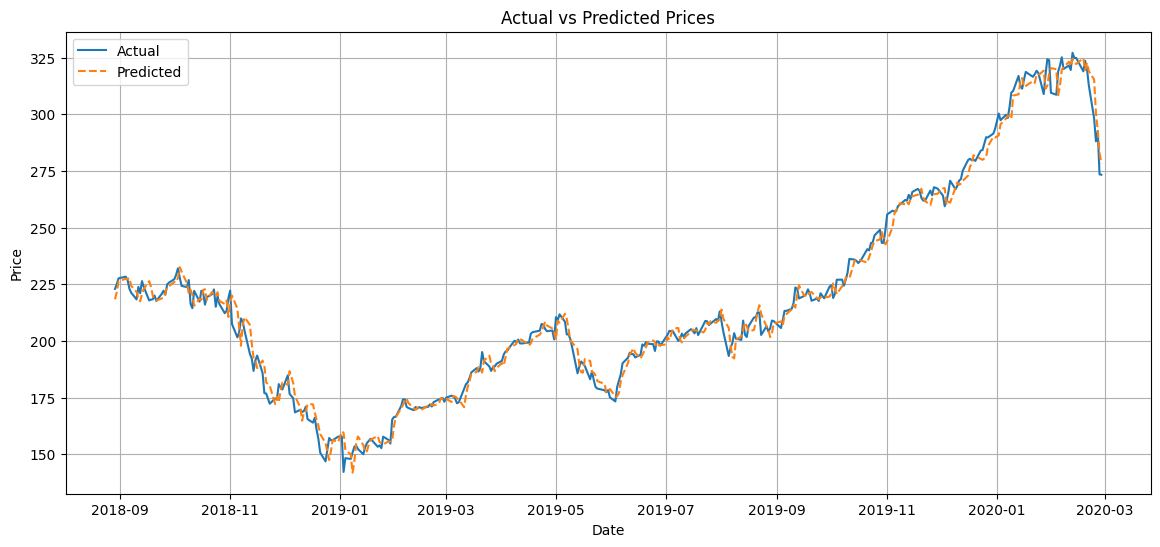

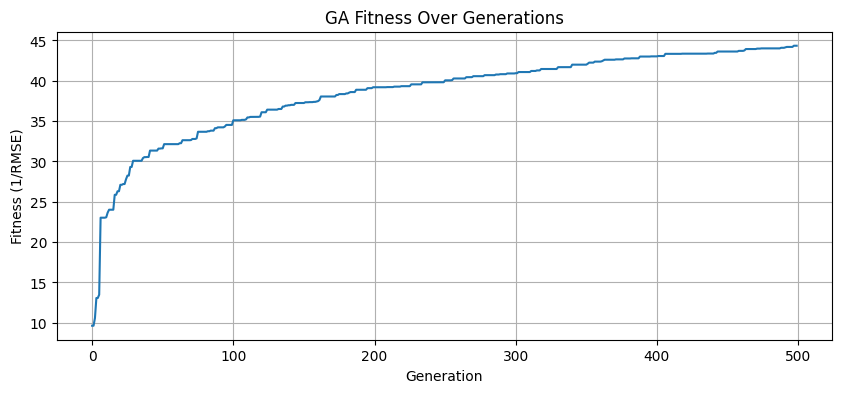

In [11]:
# Genetic Algorithm-based Neural Network for Time Series Forecasting (Improved Version)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Part 1: Data Preprocessing ---
def load_and_preprocess_data(filename, lag_days=10, feature_columns=None, target_column='Close/Last'):
    df = pd.read_csv(filename)
    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').set_index('Date')

    for col in ['Close/Last', 'Volume', 'Open', 'High', 'Low']:
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)

    if feature_columns is None:
        feature_columns = ['Close/Last', 'Volume', 'Open', 'High', 'Low']

    df_feat = df[feature_columns].copy()
    df_target = df[[target_column]].copy()
    df_target.rename(columns={target_column: 'Target'}, inplace=True)

    for col in feature_columns:
        for i in range(1, lag_days + 1):
            df_feat[f'{col}_lag_{i}'] = df_feat[col].shift(i)
    df_feat = df_feat.drop(columns=feature_columns)

    df_final = pd.concat([df_feat, df_target], axis=1).dropna()

    X = df_final.drop(columns=['Target'])
    y = df_final['Target']
    return X, y, df_final.index

# --- Part 2: Neural Network Architecture (Forward Pass Only) ---
def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

def forward_pass(X, chromosome, layer_sizes, activation='relu'):
    act_fn = relu if activation == 'relu' else tanh
    weights, biases = [], []
    idx = 0
    for i in range(len(layer_sizes) - 1):
        w_size = layer_sizes[i] * layer_sizes[i+1]
        b_size = layer_sizes[i+1]
        w = np.array(chromosome[idx:idx+w_size]).reshape(layer_sizes[i], layer_sizes[i+1])
        idx += w_size
        b = np.array(chromosome[idx:idx+b_size]).reshape(1, layer_sizes[i+1])
        idx += b_size
        weights.append(w)
        biases.append(b)

    a = X.copy()
    for i in range(len(weights) - 1):
        z = np.dot(a, weights[i]) + biases[i]
        a = act_fn(z)
    output = np.dot(a, weights[-1]) + biases[-1]
    return output.flatten()

# --- Part 3: Genetic Algorithm Implementation ---
class GeneticAlgorithm:
    def __init__(self, input_size, hidden_layers, output_size=1, population_size=100, generations=100,
                 mutation_rate=0.05, crossover_rate=0.8, elite_count=5, activation='relu'):
        self.layer_sizes = [input_size] + hidden_layers + [output_size]
        self.num_parameters = self._calculate_total_parameters()
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elite_count = elite_count
        self.activation = activation
        self.population = []
        self.fitness_history = []
        self.best_chromosome = None
        self.best_fitness = float('-inf')

    def _calculate_total_parameters(self):
        total = 0
        for i in range(len(self.layer_sizes) - 1):
            total += self.layer_sizes[i] * self.layer_sizes[i+1]  # Weights
            total += self.layer_sizes[i+1]                        # Biases
        return total

    def _initialize_population(self):
        self.population = [np.random.uniform(-1, 1, self.num_parameters).tolist() for _ in range(self.population_size)]

    def _fitness(self, chromosome, X, y):
        pred = forward_pass(X, chromosome, self.layer_sizes, self.activation)
        rmse = np.sqrt(mean_squared_error(y, pred))
        return 1 / (rmse + 1e-6)

    def _select_parents(self, pop_fit):
        parents = []
        for _ in range(2):
            competitors = random.sample(pop_fit, k=min(3, len(pop_fit)))
            winner = max(competitors, key=lambda x: x[1])
            parents.append(winner[0])
        return parents

    def _crossover(self, p1, p2):
        if random.random() > self.crossover_rate:
            return p1.copy(), p2.copy()
        point = random.randint(1, self.num_parameters - 1)
        c1 = p1[:point] + p2[point:]
        c2 = p2[:point] + p1[point:]
        return c1, c2

    def _mutate(self, chrom):
        for i in range(len(chrom)):
            if random.random() < self.mutation_rate:
                chrom[i] += random.uniform(-0.1, 0.1)
                chrom[i] = max(-1, min(1, chrom[i]))
        return chrom

    def run(self, X_train, y_train, X_val, y_val):
        self._initialize_population()

        for gen in range(self.generations):
            pop_fit = [(chrom, self._fitness(chrom, X_val, y_val)) for chrom in self.population]
            pop_fit.sort(key=lambda x: x[1], reverse=True)

            if pop_fit[0][1] > self.best_fitness:
                self.best_chromosome = pop_fit[0][0]
                self.best_fitness = pop_fit[0][1]

            self.fitness_history.append(pop_fit[0][1])
            print(f"Gen {gen+1}/{self.generations} - Best Fitness: {pop_fit[0][1]:.5f}")

            new_pop = [pf[0] for pf in pop_fit[:self.elite_count]]
            while len(new_pop) < self.population_size:
                p1, p2 = self._select_parents(pop_fit)
                c1, c2 = self._crossover(p1, p2)
                new_pop.append(self._mutate(c1))
                if len(new_pop) < self.population_size:
                    new_pop.append(self._mutate(c2))
            self.population = new_pop

        return self.best_chromosome

# --- Part 4: Evaluation & Plotting ---
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

def plot_predictions(dates, y_true, y_pred):
    plt.figure(figsize=(14, 6))
    plt.plot(dates, y_true, label='Actual')
    plt.plot(dates, y_pred, '--', label='Predicted')
    plt.legend()
    plt.title("Actual vs Predicted Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

def plot_fitness(fitness_history):
    plt.figure(figsize=(10, 4))
    plt.plot(fitness_history)
    plt.title("GA Fitness Over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness (1/RMSE)")
    plt.grid(True)
    plt.show()

# --- Part 5: Main Execution ---
if __name__ == "__main__":
    X, y, dates = load_and_preprocess_data("HistoricalQuotes.csv", lag_days=10)

    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)

    X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
    X_val, y_val = X.iloc[train_size:train_size+val_size], y.iloc[train_size:train_size+val_size]
    X_test, y_test = X.iloc[train_size+val_size:], y.iloc[train_size+val_size:]
    dates_test = dates[train_size+val_size:]

    scaler_X = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).flatten()
    y_val_scaled = scaler_y.transform(y_val.values.reshape(-1,1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()

    ga = GeneticAlgorithm(
        input_size=X_train.shape[1],
        hidden_layers=[10, 5],
        population_size=120,
        generations=500,
        mutation_rate=0.05,
        crossover_rate=0.8,
        elite_count=6,
        activation='relu'
    )

    print("\nTraining Genetic Algorithm...")
    best_chrom = ga.run(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)
    print("\nGA Training Completed.")

    test_pred_scaled = forward_pass(X_test_scaled, best_chrom, ga.layer_sizes, ga.activation)
    test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1,1)).flatten()
    y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()

    mae, mse, rmse, r2 = evaluate(y_test_orig, test_pred)
    print(f"\n--- Evaluation on Test Set ---")
    print(f"MAE : {mae:.4f}")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2 : {r2:.4f}")

    plot_predictions(dates_test, y_test_orig, test_pred)
    plot_fitness(ga.fitness_history)



--- Trading Performance Metrics ---
Initial Capital: $100,000.00
Final Portfolio Value: $136,539.81
Total Return: 36.54%
Annualized Return: 23.14%
Max Drawdown: -21.43%
Sharpe Ratio: 1.05
Total Trades: 102
Profitable Trades: 40
Win Rate: 78.43%
Buy and Hold Return: 22.59%


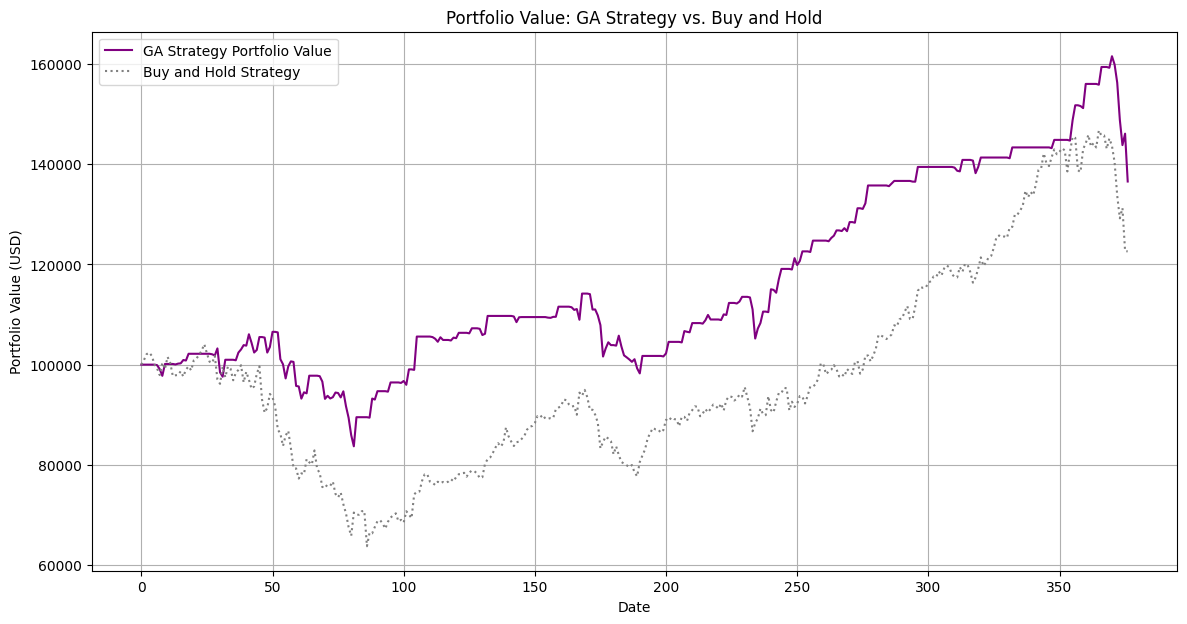

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random

# --- Assumes best_weights and predictions already available ---
try:
    _ = y_test_actual
except NameError:
    print("Previous GA prediction code variables not found. Generating dummy data for backtesting demonstration.")
    dates = pd.to_datetime(pd.date_range(start='2023-01-01', periods=100, freq='D'))
    y_test_actual = np.sin(np.arange(100)/10) * 50 + 150 + np.random.randn(100) * 5
    test_predictions_original = y_test_actual + np.random.randn(100) * 2
    y_test_actual = pd.Series(y_test_actual, index=dates)
    test_predictions_original = pd.Series(test_predictions_original, index=dates)
    df_close = pd.DataFrame({'Close': y_test_actual}, index=dates)

# --- Trading Simulation ---
initial_capital = 100000.0
transaction_cost_rate = 0.001
portfolio_value = [initial_capital]
holdings = 0
cash = initial_capital
trades_count = 0
profitable_trades = 0
trade_profits = []
is_holding = False
buy_price = 0

trading_df = pd.DataFrame({
    'Actual_Price': y_test_actual,
    'Predicted_Price': test_predictions_original
})

for i in range(len(trading_df) - 1):
    current_actual_price = trading_df['Actual_Price'].iloc[i]
    predicted_next_price = trading_df['Predicted_Price'].iloc[i]

    if predicted_next_price > current_actual_price * 1.001 and not is_holding:
        shares_to_buy = int(cash // (current_actual_price * (1 + transaction_cost_rate)))
        if shares_to_buy > 0:
            cost = shares_to_buy * current_actual_price
            transaction_fee = cost * transaction_cost_rate
            cash -= (cost + transaction_fee)
            holdings += shares_to_buy
            buy_price = current_actual_price
            is_holding = True
            trades_count += 1

    elif predicted_next_price < current_actual_price * 0.999 and is_holding:
        revenue = holdings * current_actual_price
        transaction_fee = revenue * transaction_cost_rate
        cash += (revenue - transaction_fee)
        trade_pl = (current_actual_price - buy_price) * holdings - (holdings * buy_price * transaction_cost_rate) - (holdings * current_actual_price * transaction_cost_rate)
        trade_profits.append(trade_pl)
        if trade_pl > 0:
            profitable_trades += 1
        holdings = 0
        is_holding = False
        trades_count += 1

    current_portfolio_val = cash + (holdings * current_actual_price)
    portfolio_value.append(current_portfolio_val)

if is_holding:
    final_price = trading_df['Actual_Price'].iloc[-1]
    revenue = holdings * final_price
    transaction_fee = revenue * transaction_cost_rate
    cash += (revenue - transaction_fee)
    trade_pl = (final_price - buy_price) * holdings - (holdings * buy_price * transaction_cost_rate) - (holdings * final_price * transaction_cost_rate)
    trade_profits.append(trade_pl)
    if trade_pl > 0:
        profitable_trades += 1
    holdings = 0
    is_holding = False
    trades_count += 1

if len(portfolio_value) == len(trading_df['Actual_Price']) + 1:
    portfolio_value_series = pd.Series(portfolio_value[1:], index=trading_df.index)
else:
    portfolio_value_series = pd.Series(portfolio_value, index=trading_df.index[:len(portfolio_value)])

# --- Trading Metrics ---
total_return = (portfolio_value_series.iloc[-1] - initial_capital) / initial_capital * 100
num_trading_days = len(trading_df)
annualization_factor = 252.0 / num_trading_days
annual_return = ((portfolio_value_series.iloc[-1] / initial_capital)**annualization_factor - 1) * 100
peak_value = portfolio_value_series.expanding(min_periods=1).max()
drawdown = (portfolio_value_series - peak_value) / peak_value
max_drawdown = drawdown.min() * 100
daily_returns = portfolio_value_series.pct_change().dropna()
risk_free_rate = 0.0
excess_returns = daily_returns - risk_free_rate
if np.std(excess_returns) == 0:
    sharpe_ratio = 0
else:
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

win_rate = (profitable_trades / len(trade_profits)) * 100 if len(trade_profits) > 0 else 0
buy_hold_start_price = trading_df['Actual_Price'].iloc[0]
buy_hold_end_price = trading_df['Actual_Price'].iloc[-1]
buy_hold_return = ((buy_hold_end_price - buy_hold_start_price) / buy_hold_start_price) * 100

print("\n--- Trading Performance Metrics ---")
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Portfolio Value: ${portfolio_value_series.iloc[-1]:,.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {annual_return:.2f}%")
print(f"Max Drawdown: {max_drawdown:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Total Trades: {trades_count}")
print(f"Profitable Trades: {profitable_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Buy and Hold Return: {buy_hold_return:.2f}%")

# --- Plotting ---
plt.figure(figsize=(14, 7))
plt.plot(portfolio_value_series.index, portfolio_value_series, label='GA Strategy Portfolio Value', color='purple')
buy_hold_portfolio_value = (trading_df['Actual_Price'] / trading_df['Actual_Price'].iloc[0]) * initial_capital
plt.plot(buy_hold_portfolio_value.index, buy_hold_portfolio_value, label='Buy and Hold Strategy', color='grey', linestyle=':')
plt.title('Portfolio Value: GA Strategy vs. Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()
